In [1]:
import os
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as pth
from PIL.Image import *
from matplotlib import cm
from PIL import Image
import cv2
from PIL import Image

In [2]:
import site
print(site.getsitepackages())

['C:\\Anaconda', 'C:\\Anaconda\\lib\\site-packages']


In [60]:
def multiple_imshow(rows,cols,images ,titles):

    plt.figure(len(images), figsize=(12, 12))
    for i in range(len(images)):
        plt.subplot(rows,cols,i+1)
        plt.imshow(images[i],'gray')
        plt.title(titles[i])
        #plt.xticks([]),plt.yticks([]) 
    plt.show()

def defect_detection(path,lower_bound,upper_bound,lower_bound_1 = [0,0,0],upper_bound_1 =[0,0,0]):
    
    img = cv2.imread(path,1)  # BGR color image reading and 0 flag for gray
    
    #blur = cv2.GaussianBlur(img,(5,5),0) #not good results
    #kernel = np.ones((5,5),np.float32)/25 #averaging is not satisfying as well
    #dst = cv2.filter2D(img,-1,kernel)
    #median = cv2.medianBlur(img,5)#median as well
    
    # converting it into Hue, saturation, value (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
   
    '''Threshold'''
    
    # define range of red color in HSV
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    
    # Threshold the HSV image to get only red colors
    mask_0 = cv2.inRange(hsv, lower, upper)
    mask_1 = cv2.inRange(hsv,np.array(lower_bound_1),np.array(upper_bound_1))
    mask =mask_0 + mask_1
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask = mask)
    
    return res


def pre_shaping(image,resol = [284,348]):
    
    #width = resol[1]
    #height = resol[0]
    #dim = (width, height) 
    
    # resize image
    #resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)#INTER_LINEAR_EXACT) 
    
    img = image
    rows,cols = img.shape
    
    frame = [[0,0],[cols,0],[0,rows],[cols,rows]]
    dimension = [[0,0],[resol[1],0],[0,resol[0]],[resol[1],resol[0]]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    resized = cv2.warpPerspective(img,M,(resol[1],resol[0]))
    
    return resized

def real_shaping(normalized_image,rows_dim,cols_dim,i = 8,j = 17):
    
    img = normalized_image
    rows,cols = img.shape
    
    frame = [[i,j],[rows,j],[i,cols],[rows,cols]]
    dimension = [[0,0],[cols_dim,0],[0,rows_dim],[cols_dim,rows_dim]]

    pts1 = np.float32(frame)
    pts2 = np.float32(dimension)

    M = cv2.getPerspectiveTransform(pts1,pts2)

    real_shape = cv2.warpPerspective(img,M,(cols_dim,rows_dim))
    
    return real_shape

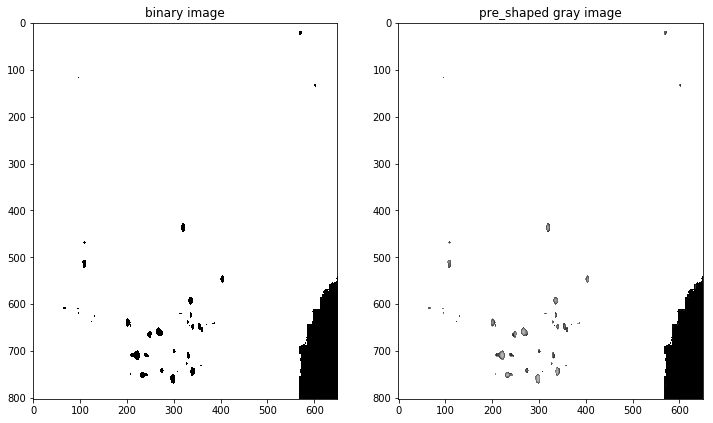

In [61]:
'''Functions call'''

path = "C:/Users/elh/Desktop/xy.png"

''' Big defects : red_yellow'''

lower_bound = [0,0,0]
upper_bound = [90,255,255] # for more defects the upper bound can go till ~105

res = defect_detection(path,lower_bound,upper_bound,[150,0,0],[179,255,255])

"""Binary image to detect the center"""
imgray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY) #convert to gray

#binary thresholding 
ret,thresh = cv2.threshold(imgray,0,1,cv2.THRESH_BINARY)
#th2 = cv2.adaptiveThreshold(imgray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            #cv2.THRESH_BINARY,11,2) #consider some defects as noise


title = 'Global Thresholding (big defects)'

'''shaping'''
#gray image

#img = pre_shaping(img,resol = [350,285])
images = [255-thresh,255-imgray]#255-img]#i,j --> y,x
titles = ['binary image','pre_shaped gray image']

multiple_imshow(1,2,images ,titles)

In [62]:
#pre_processed_img = imgray # pre_shaped gray image
pre_processed_img = cv2.GaussianBlur(imgray,(3,3),0)

In [63]:
def add_neighbours_in_stack(image, a, b, stack, i, j, inComponent):

    inComponent[i, j] = True
    neighbours = [(i+1,j),(i-1,j),(i,j-1),(i,j+1)]
    #neighbours = [(i-1,j-1),(i+1,j-1),(i+1,j),(i-1,j),(i,j-1),(i,j+1),(i-1,j+1),(i+1,j+1)]
    for (k,l) in neighbours:
        if 0<=k<image.shape[0] and 0<=l<image.shape[1]:
            if (image[k,l]>a and image[k,l]<b) and not inComponent[k, l]:
                inComponent[k, l] = True
                stack.append((k,l))
    return 

def connected_component_nb(image, seuil, i0,j0, inComponent):
    stack = [(i0,j0)]
    defect = []
    nb=1
    barycentre = [i0,j0]
    while len(stack)>0:
        (i,j) = stack.pop()
        nb+=1  
        add_neighbours_in_stack(image, seuil, 260, stack, i, j, inComponent)
        
        defect.append((i,j))
        barycentre[0] += i
        barycentre[1] += j
            
    barycentre[0] /= nb
    barycentre[1] /= nb
    
    return nb, barycentre,defect


def all_connected_components(image, seuil):

    inComponent = np.empty(image.shape, dtype=np.bool)
    inComponent[:, :] = False # stoping test

    baryAndSizes = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j]>seuil and not inComponent[i,j]:
                baryAndSizes.append(connected_component_nb(image,seuil,i,j,inComponent))
                
    return baryAndSizes


def step2(image,defect_nb,thresh):
    
    imageR = image
    imageB = image

    baryAndSizesR = all_connected_components(imageR, thresh)
    baryAndSizesB = all_connected_components(imageB, thresh)
    
    xR, xB = np.array([],dtype=int), np.array([],dtype=int)
    yR, yB = np.array([],dtype=int), np.array([],dtype=int)
    sizeR, sizeB = np.array([]), np.array([]) 
    
    for i in range(len(baryAndSizesR)):
        xR = np.append(xR, baryAndSizesR[i][1][0])
        yR = np.append(yR, baryAndSizesR[i][1][1])
        sizeR = np.append(sizeR, baryAndSizesR[i][0])
    
    for i in range(len(baryAndSizesB)):
        xB = np.append(xB, baryAndSizesB[i][1][0])
        yB = np.append(yB, baryAndSizesB[i][1][1])
        sizeB = np.append(sizeB, baryAndSizesB[i][0])
    
    '''plot'''
    fig, ax = plt.subplots(1,3, figsize = (22,12))
    fig.suptitle('Results', fontsize=16)
    ax[0].set_xlim(0,imageR.shape[1])
    ax[1].set_xlim(0,imageB.shape[1])
    ax[2].set_xlim(0,imageB.shape[1])
    
    title = ['Detected defects centers','Detected defects as discs']
    ax[0].imshow(255-imageR, cmap='gray', vmin = 0, vmax = 255,)
    ax[0].scatter(yR, xR, marker='+', s=sizeR, c = 'r', alpha = 0.5)
    ax[0].set_title(title[0])
    
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    ax[1].imshow(255-imageB, cmap='gray', vmin = 0, vmax = 255,)
    ax[1].scatter(yB, xB, marker='o', s=sizeB, c = 'b', alpha = 0.5)
    ax[1].set_title(title[1])
    
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    
    '''defects list''' 
    #print(baryAndSizesB[0][2])#exemple of defect 0
    test = np.array([],dtype=int)
    test = baryAndSizesB[defect_nb][2] #i.e defect number 10
    test_x = np.ndarray(len(test))
    test_y = np.ndarray(len(test))
    for i in range(len(test)):
        test_x[i] = test[i][1] #x axis
        test_y[i] = test[i][0] #y axis
    
    ax[2].imshow((255-imageR), cmap='gray', vmin = 0, vmax = 255,)
    ax[2].scatter(test_x, test_y, marker='o', s=1, c = 'b', alpha = 0.5)

    test = np.stack((test_x, image.shape[0]-test_y), axis=1)
    
    plt.show()
    
    return yR, image.shape[0]-xR, sizeR,test

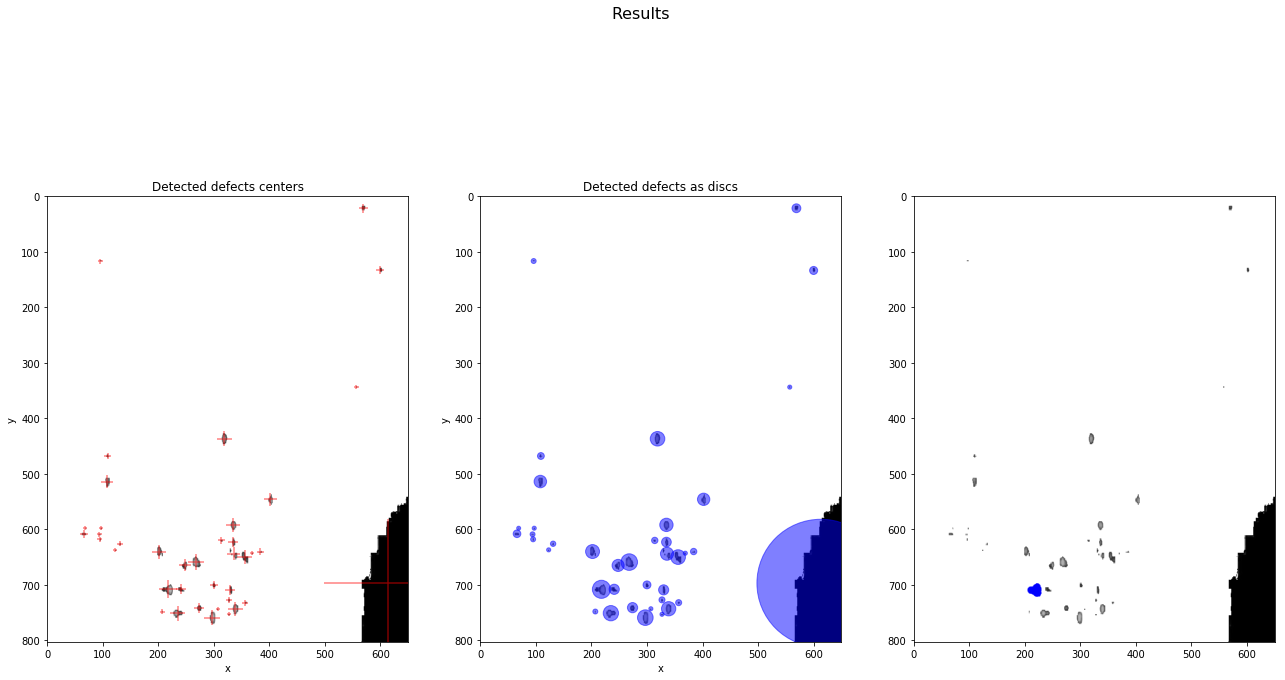

39


In [64]:
'''Call function'''
image = pre_processed_img

x, y,area ,test= step2(image,27,0)#32 no bluring
xy = np.stack((x, y), axis=1)
print len(x)


# Rolling window 1D

In [65]:
def rolling_window(data, window_length):
    output_shape = data.shape[:-1] + (data.shape[-1] - window_length + 1, window_length)
    strides = data.strides + (data.strides[-1],)
    return np.lib.stride_tricks.as_strided(data, shape=output_shape, strides=strides)

In [66]:
def findLocalMax(data,windowLength,alsoDetectBorderPick=False):
    dataRoll=rolling_window(data,windowLength)
    armax=np.argmax(dataRoll,axis=1)
    where=np.where(armax==(windowLength//2))
    res = where[0]+windowLength//2
    if alsoDetectBorderPick:
        if armax[0]==0:
            res = np.append(res, 0)
        if armax[-1]==windowLength-1:
            res = np.append(res, len(data)-1)
    return np.sort(res)

In [67]:
data=np.eye(8)
data[1]=3

In [68]:
roll=rolling_window(data,3)
roll

array([[[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]],

       [[0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0

In [69]:
roll.shape

(8L, 6L, 3L)

In [70]:
np.argmax(roll,axis=1)

array([[0, 0, 0],
       [0, 0, 0],
       [2, 1, 0],
       [3, 2, 1],
       [4, 3, 2],
       [5, 4, 3],
       [0, 5, 4],
       [0, 0, 5]], dtype=int64)

In [71]:
np.where(np.argmax(roll,axis=1)==3//2)

(array([2, 3], dtype=int64), array([1, 2], dtype=int64))

[0 4]
[1.5 1.  1.  2.  2.2 1.  2. ]


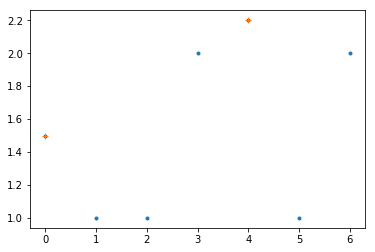

In [72]:
"""programme de test. 
Quel formule relie data.shape, windowLength et dataRoll.shape ?
Réponse : donnée ci-dessus
"""
data=np.ones(7)
data[0]=1.5
data[3]=2
data[4]=2.2
data[6]=1.1
data[-1]=2
plt.plot(range(len(data)),data,".");
plt.xticks(range(len(data)));

locMax=findLocalMax(data,3, True)
print(locMax)
plt.plot(locMax,data[locMax],"+");
print data

# Rolling window 2D

## max fonction

In [73]:
""" this function produce a rolling window which is just a view on the data: 
= a special way to move in the data. No copy is made.
"""
def rolling_windows_img(a,kshape):
    outShape=(a.shape[0]-kshape[0]+1,)+(a.shape[1]-kshape[1]+1,)+kshape
    outStrides=a.strides+a.strides
    return np.lib.stride_tricks.as_strided(a,shape=outShape,strides=outStrides)

In [74]:
def findLocalMax(data,kshape,minimum):
    
    dataRoll = rolling_windows_img(data,kshape)
    a,b = dataRoll.shape[0],dataRoll.shape[1]
    L = a*b
    W = kshape[0]*kshape[1]
    dataRoll = dataRoll.reshape(L,W)
    
    if minimum == True:
        armin = np.argmin(dataRoll,axis=1)
    else:
        armin = np.argmax(dataRoll,axis=1)
    
   
    res=np.array([])
    for i, j in enumerate(armin):
        if j == W//2:
            where = np.where((dataRoll[i,:] == dataRoll[i,j]) & (dataRoll[i,j] > 0))[0]

            #if (W//2 in where) :
            coord = np.array([(i//b)+ kshape[0]//2,(i%a)+ kshape[1]//2])
            res = np.append(res, coord)

    res = res.reshape(res.size//2,2)            
    print (res)
    
    return np.sort(res)

In [75]:
inputs=np.ones((5,5))*2

inputs[1,1]=1
inputs[0,2]=1
inputs[3,3]=1
findLocalMax(inputs,(3,3),True)
inputs

[[3. 3.]]


array([[2., 2., 1., 2., 2.],
       [2., 1., 2., 2., 2.],
       [2., 2., 2., 2., 2.],
       [2., 2., 2., 1., 2.],
       [2., 2., 2., 2., 2.]])

## Defect function

In [76]:
def get_defect_intensity(img,defect): #pixel should np.array (x,y)
    
    defect = np.array(defect,dtype=np.uint64)
    intensity = img[img.shape[0]-defect[:,1],defect[:,0]]
    
    return intensity

In [77]:
defect = np.array(test,dtype=np.uint64)
img = image
#img = cv2.GaussianBlur(image,(3,3),0)
test.shape,img.shape

((328L, 2L), (803L, 650L))

In [78]:
get_defect_intensity(img,defect).shape

(328L,)

In [79]:
i_min = np.min(img.shape[0]-defect[:,1])
i_max = np.max(img.shape[0]-defect[:,1]+1)
j_min = np.min(defect[:,0])
j_max = np.max(defect[:,0]+1)

In [80]:
img[i_min:i_max,j_min:j_max][img[i_min:i_max,j_min:j_max]!= 0].shape\
== get_defect_intensity(img,defect).shape

True

In [81]:
defect_shape = img[i_min:i_max,j_min:j_max].shape
dim = np.max(defect_shape)
case = np.zeros((dim,dim))
case[0:defect_shape[0],0:defect_shape[1]] = img[i_min:i_max,j_min:j_max].copy()
df = pd.DataFrame(case)
df

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,7.0,23.0,33.0,25.0,8.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,25.0,79.0,108.0,81.0,26.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,38.0,70.0,127.0,157.0,129.0,60.0,11.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,81.0,116.0,129.0,145.0,152.0,145.0,101.0,31.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,...,126.0,153.0,145.0,133.0,126.0,134.0,121.0,60.0,10.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.0,...,149.0,141.0,122.0,108.0,102.0,113.0,128.0,97.0,31.0,0.0
6,0.0,0.0,9.0,30.0,43.0,42.0,35.0,32.0,38.0,76.0,...,148.0,121.0,102.0,90.0,87.0,98.0,125.0,118.0,54.0,7.0
7,0.0,0.0,31.0,98.0,138.0,132.0,110.0,102.0,122.0,152.0,...,132.0,103.0,88.0,82.0,81.0,88.0,113.0,127.0,85.0,23.0
8,8.0,29.0,80.0,159.0,200.0,190.0,160.0,149.0,172.0,190.0,...,121.0,95.0,83.0,79.0,78.0,84.0,108.0,135.0,109.0,36.0
9,26.0,89.0,153.0,195.0,210.0,200.0,175.0,163.0,176.0,185.0,...,115.0,92.0,81.0,78.0,77.0,82.0,104.0,135.0,116.0,41.0


## defect minima

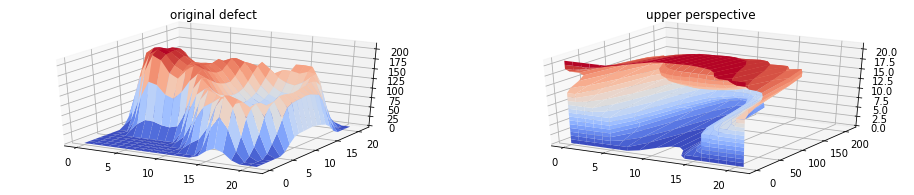

In [82]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=plt.figaspect(0.2))
ax0 = fig.add_subplot(1, 2, 1, projection='3d')


# Make data.
X = np.arange(0, case.shape[0], 1)
Y = np.arange(0, case.shape[0], 1)
X, Y = np.meshgrid(X, Y)
Z = (case,case)

# Plot the surface.
surf0 = ax0.plot_surface(X, Y, Z[0], cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)

# Customize the z axis.
#ax0.set_zlim(0, 255)
#ax0.zaxis.set_major_locator(LinearLocator(10))
#ax0.zaxis.set_major_formatter(FormatStrFormatter('%.d'))

# Add a color bar which maps values to colors.

ax1 = fig.add_subplot(1, 2, 2, projection='3d')

surf1 = ax1.plot_surface( Y, Z[0],X, cmap=cm.coolwarm,
                       linewidth=1, antialiased=True)

ax0.set_title('original defect')
ax1.set_title('upper perspective')
plt.savefig('fig')

plt.show()

### Minimum

In [83]:
mini = findLocalMax(case,(3,3),True) #i,j

[[ 9. 16.]
 [11. 14.]]


In [84]:
points = np.where(case!=0)
pts = np.stack((points[1],points[0]),axis =-1)

[ 9. 16.]
[11. 14.]


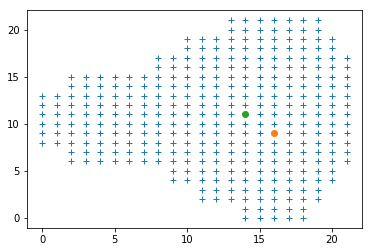

In [85]:
plt.plot(pts[:,0],pts[:,1],"+");
for centroid in mini: #reverse a
    print centroid
    plt.plot(centroid[1],centroid[0],"o")

### Maximum

In [86]:
maxi = findLocalMax(case,(3,3),False) #i,j

[[ 2. 16.]
 [ 4. 13.]
 [ 8.  9.]
 [ 8. 19.]
 [ 9.  4.]
 [13.  9.]
 [15. 19.]
 [17. 12.]
 [19. 16.]]


In [87]:
points = np.where(case!=0)
pts = np.stack((points[1],points[0]),axis =-1)

[ 2. 16.]
[ 4. 13.]
[8. 9.]
[ 8. 19.]
[4. 9.]
[ 9. 13.]
[15. 19.]
[12. 17.]
[16. 19.]


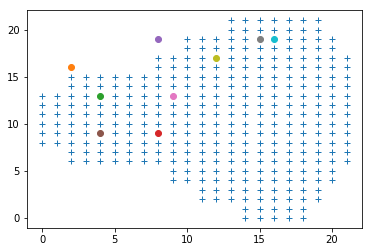

In [88]:
plt.plot(pts[:,0],pts[:,1],"+");
for centroid in maxi:
    print centroid
    plt.plot(centroid[0],centroid[1],"o")

## Kmeans

In [89]:
from sklearn.cluster import KMeans

In [90]:
"""creation of the algo"""
kmeans=KMeans(n_clusters=2)
"""computation of centroids"""
a= kmeans.fit(pts)
"""here is the result"""
#kmeans.cluster_centers_
a

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

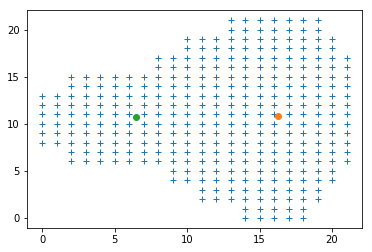

In [91]:
plt.plot(pts[:,0],pts[:,1],"+");
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")

In [92]:
kmeans.cluster_centers_ = np.array([[ 3. , 8.],[15.,  8.]])

In [93]:
labels = kmeans.predict(pts)
labels.size == pts[:,1].size

True

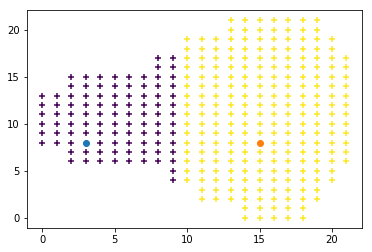

In [94]:
plt.scatter(pts[:,0],pts[:,1],c=labels,marker="+")
for centroid in kmeans.cluster_centers_:
    plt.plot(centroid[0],centroid[1],"o")

# covariance error ellipse

## post

In [95]:
l=pts[:,0]
k=pts[:,1]

In [96]:
labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [97]:
l

array([14, 15, 16, 17, 18, 14, 15, 16, 17, 18, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 11, 12, 13, 14, 15, 16, 17, 18, 19,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  0,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
        0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,  0,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21,  2,  3

In [98]:
a=l[labels!=0]
b=k[labels!=0]
a.size == b.size

True

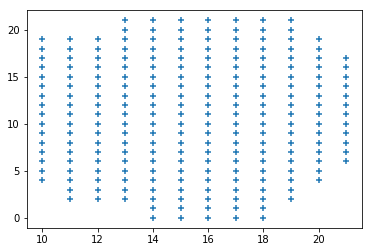

In [99]:
plt.scatter(a,b,marker="+")

In [4]:
ab = np.stack((a,b),axis=0)
ab

NameError: name 'np' is not defined

In [101]:
cov = np.cov(ab)
cov

array([[10.35777482,  0.33597874],
       [ 0.33597874, 33.20009493]])

In [102]:
np.cov(a,b)

array([[10.35777482,  0.33597874],
       [ 0.33597874, 33.20009493]])

In [103]:
from numpy import linalg as LA
w, v = LA.eig(cov)
w


array([10.35283411, 33.20503564])

In [104]:
v

array([[-0.99989189, -0.01470384],
       [ 0.01470384, -0.99989189]])

In [105]:
a0=np.mean(a)
b0=np.mean(b)

In [106]:
angle = np.arctan(v[1,1]/v[0,1])
angle = math.degrees(angle)
angle


89.15750179978895

In [107]:
sigmax= 2*np.sqrt(5.991*w[0])
sigmay= 2*np.sqrt(5.991*w[1])


## Plot

https://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix/

In [108]:
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import math

In [2]:

xcenter, ycenter = a0, b0
width, height = w[0], w[1]
angle = np.arctan(v[1,1]/v[0,1])

theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
x =2 * width * np.cos(theta)
y = 2 * height * np.sin(theta)

rtheta = np.radians(angle)
R = np.array([
    [np.cos(rtheta), -np.sin(rtheta)],
    [np.sin(rtheta),  np.cos(rtheta)],
    ])


x, y = np.dot(R, np.array([x, y]))
x += a0
y += b0

fig = plt.figure()
ax = fig.add_subplot(211, aspect='auto')
ax.fill(x, y, alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

e1 = patches.Ellipse((xcenter, ycenter), width, height,
                     angle=angle, linewidth=2, fill=False, zorder=2)
ax.add_patch(e1)

NameError: name 'a0' is not defined

In [3]:

fig = plt.figure()
ax = fig.add_subplot(211, aspect='auto')
ax.fill(a, b, alpha=0.2, facecolor='yellow',
        edgecolor='yellow', linewidth=1, zorder=1)

#The -angle is used because it defines the angle clockwise instead of anti-clockwise
e1 = patches.Ellipse((a0, b0), sigmax, sigmay,
                     angle=-angle, linewidth=2, fill=False, zorder=2)

ax.add_patch(e1)

ax.set_xlim(7,30)#ax.set_xlim(-5, 15)
ax.set_ylim(-5, 30)


NameError: name 'plt' is not defined

## Gradient descent